In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
%matplotlib inline

                               Open      High       Low     Close      Volume  \
Date                                                                            
1986-03-13 00:00:00-05:00  0.054693  0.062736  0.054693  0.060055  1031788800   
1986-03-14 00:00:00-05:00  0.060055  0.063272  0.060055  0.062199   308160000   
1986-03-17 00:00:00-05:00  0.062199  0.063808  0.062199  0.063272   133171200   
1986-03-18 00:00:00-05:00  0.063272  0.063808  0.061127  0.061663    67766400   

                           Dividends  Stock Splits  
Date                                                
1986-03-13 00:00:00-05:00        0.0           0.0  
1986-03-14 00:00:00-05:00        0.0           0.0  
1986-03-17 00:00:00-05:00        0.0           0.0  
1986-03-18 00:00:00-05:00        0.0           0.0  


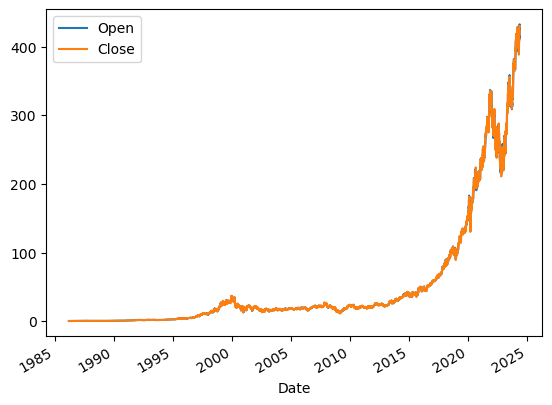

In [36]:
# Yahoo Finance has a nice API
import yfinance as yahooFinance
# GetInformation = yahooFinance.Ticker("^IXIC")
GetInformation = yahooFinance.Ticker("MSFT")
# GetInformation = yahooFinance.Ticker("C")
df = GetInformation.history(period="max")
print(df.head(4))
df.plot(y=['Open','Close'])
plt.show()

In [37]:
def create_time_windows(df, n_window ,n_forecast, scale=True ): 
    '''
        This creates a rolling time window (X,y) from the Pandas DataFrame df, and store it in a numpy array of size (nsamples, n_window/n_forecast, nfeatures)
        n_features referr to open/close/volume etc, while also going through a min-max scaler from -1 to 1 for all time windows
    '''
    N, N_features = len(df), len(list(df))
    X, y = [], []
    sc = MinMaxScaler(feature_range=(0,1))
    df1 = sc.fit_transform(df)
    # df1 = df.to_numpy()
    for i in range(n_window,N-n_forecast):
        tmp = df1[(i-n_window):(i+n_forecast),...]
        X.append(tmp[:n_window,...])
        y.append(tmp[n_window:,...])
        
    return np.array(X), np.array(y), sc

In [38]:
n_window, n_forecast = 8*5, 1
df1 = pd.DataFrame({'Open':df['Open']})
# use MaxAbsScaler, therefore preserving 0 to be the zero return. 
X, y, scaler = create_time_windows(df1, n_window = n_window, n_forecast = n_forecast, scale=False)

Nsamples = X.shape[0]
Ntrain = int(Nsamples * 0.8) 
Xtrain, ytrain = X[:Ntrain,...], y[:Ntrain,...]
Xtest, ytest = X[Ntrain:,...], y[Ntrain:,...]

In [40]:
nfeatures = 1 # only use first nfeature columns for training and prediction
model5= keras.Sequential([keras.Input(shape=(None,nfeatures)),
                          keras.layers.LSTM(32,return_sequences=True),
                          keras.layers.Dropout(0.2),
                          keras.layers.LSTM(32,return_sequences=False),
                          keras.layers.Dropout(0.2),
                          keras.layers.Dense(n_forecast)])
model5.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss='mse')
ntrain = int(Xtrain.shape[0]*0.8)
history = model5.fit(Xtrain[:ntrain,:,:nfeatures],ytrain[:ntrain,:,0], batch_size= 32,
                     epochs = 100,validation_data=(Xtrain[ntrain:,:,:nfeatures],ytrain[ntrain:,:,0]))
# model5.save('models/Classification_SimpleRNN_Return_NextDay_May28_920PM.keras')

Epoch 1/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.6489e-04 - val_loss: 8.3393e-06
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.4000e-05 - val_loss: 1.6365e-05
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.1131e-05 - val_loss: 5.2588e-06
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 9.2282e-06 - val_loss: 5.8764e-06
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 9.7852e-06 - val_loss: 6.0307e-06
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 9.2183e-06 - val_loss: 7.3412e-06
Epoch 7/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.9882e-06 - val_loss: 1.1905e-05
Epoch 8/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 8.3984e-06 - val_loss: 5.0963e-06
Epoch 9/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 8.1426e-06 - val_loss: 1.0771e-05
Epoch 10/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.6940e-06 - val_loss: 4.3496e-06
Epoch 11/100
192/192 ━━━━━━━━━━━━━━━━━━

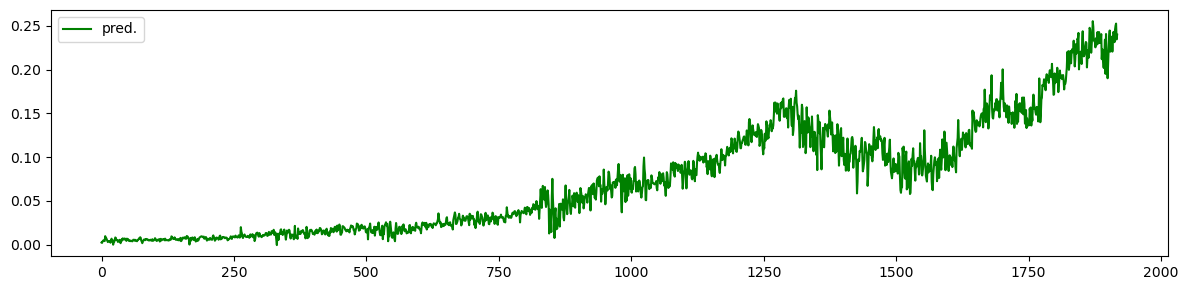

In [42]:
# plot predictions based on model 2
def plot_forecast(X,y,model):
    # only do this for the test data set! 
    ypred = model(X[:,:,:1])
    fig = plt.figure(figsize=(12,3))
    # plt.plot(y[:,0,0],"r-",label="actual")
    # plt.plot(ypred[:,0],"g-",label="pred.")
    plt.plot(y[:,0,0]-ypred[:,0],"g-",label="pred.")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close(fig)
plot_forecast(Xtest,ytest,model=model5)

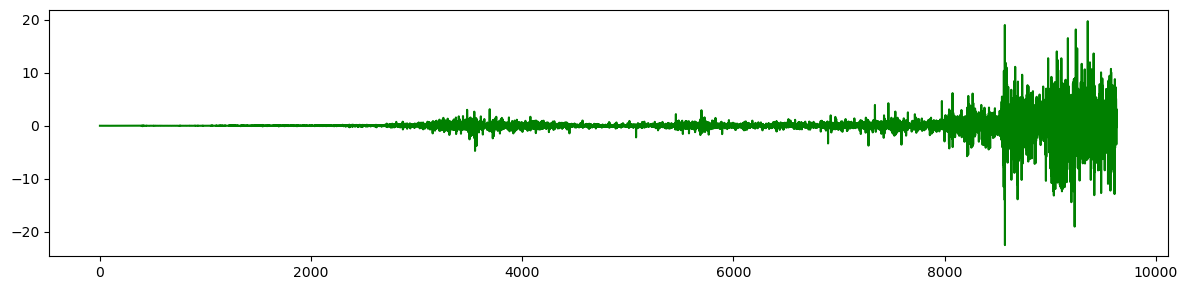

In [30]:
fig = plt.figure(figsize=(12,3))
plt.plot(range(len(df)),df['Close'].diff(),"g-")
plt.tight_layout()
plt.show()
plt.close(fig)

# LSTM 
- prediction looks like a lagged version of actual result

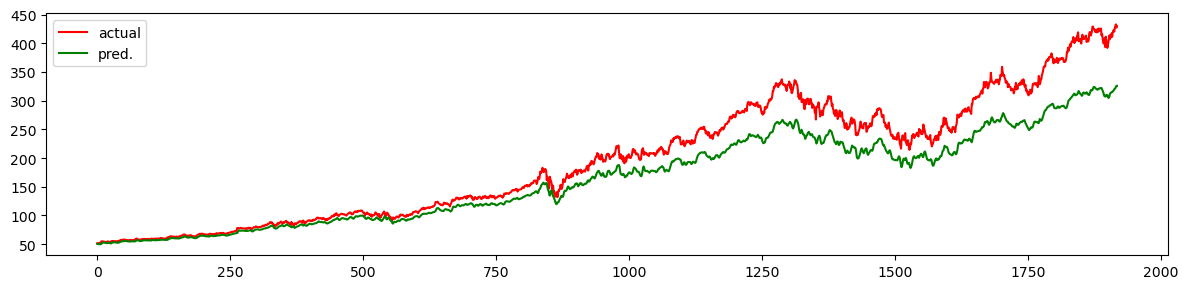

In [49]:
# plot predictions based on model 2
def plot_forecastv1(X,y,model):
    # only do this for the test data set! 
    ypred = model(X[:,:,:1]).numpy().reshape(-1,1,1)
    yactual = y.copy()
    # revert to original form
    for i in range(ypred.shape[0]):
        ypred[i,:,:] = scaler.inverse_transform(ypred[i,:,:])
        yactual[i,:,:] = scaler.inverse_transform(yactual[i,:,:])
    
    fig = plt.figure(figsize=(12,3))
    # for days in [200,40,1]:
    #     tmp = df1.rolling(days).mean().fillna(0).to_numpy()
    #     tmp = tmp / (tmp.max()-tmp.min())
    #     plt.plot(tmp,"-",label=f"rolling {days}",ms=0.5,markeredgecolor=None)
    

    plt.plot(yactual[:,0,0],"r-",label="actual")
    plt.plot(ypred[:,0,0],"g-",label="pred.")
    plt.yticks([50,100,150,200,250,300,350,400,450])
    # plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close(fig)
plot_forecastv1(Xtest,ytest,model=model5)